In [50]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Importing the Required Libraries

In [7]:
import numpy as np
import pandas as pd 
import tensorflow as tf
import zipfile
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

Define Constants

In [6]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Prepare Traning Data

In [4]:
def extract_files(source_path, target_path):
    zip_ref = zipfile.ZipFile(source_path,'r')
    zip_ref.extractall(target_path)
    zip_ref.close()

In [5]:
extract_files('/kaggle/input/dogs-vs-cats/test1.zip','/kaggle/working/')
extract_files('/kaggle/input/dogs-vs-cats/train.zip','/kaggle/working/')


In [9]:
filenames = os.listdir("input/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

In [10]:
df.head()

,filename,category
0,cat.0.jpg,0
1,cat.1.jpg,0
2,cat.10.jpg,0
3,cat.100.jpg,0
4,cat.1000.jpg,0


In [11]:
df.tail()

,filename,category
24995,dog.9995.jpg,1
24996,dog.9996.jpg,1
24997,dog.9997.jpg,1
24998,dog.9998.jpg,1
24999,dog.9999.jpg,1


See Total In count

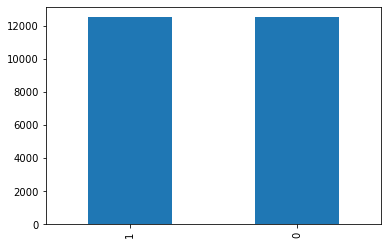

In [12]:
df['category'].value_counts().plot.bar()

See sample image

In [45]:
sample = "cat.3.jpg"
image = load_img("/input/train/"+sample)
plt.imshow(image)

FileNotFoundError: [Errno 2] No such file or directory: '/input/train/cat.3.jpg'

Build Model

Input Layer: It represent input image data. It will reshape image into single diminsion array. Example your image is 64x64 = 4096, it will convert to (4096,1) array.
Conv Layer: This layer will extract features from image.
Pooling Layer: This layerreduce the spatial volume of input image after convolution.
Fully Connected Layer: It connect the network from a layer to another layer
Output Layer: It is the predicted values layer.

In [26]:
model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_1 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0

Callbacks

In [27]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


Early Stop

To prevent over fitting we will stop the learning after 10 epochs and val_loss value not decreased

In [28]:
earlystop = EarlyStopping(patience=10)

Learning Rate Reduction

We will reduce the learning rate when then accuracy not increase for 2 steps

In [29]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

In [30]:
callbacks = [earlystop, learning_rate_reduction]

Prepare data

Because we will use image genaretor with class_mode="categorical". We need to convert column category into string. Then imagenerator will convert it one-hot encoding which is good for our classification.

So we will convert 1 to dog and 0 to cat

In [31]:
df["category"] = df["category"].replace({0: 'cat', 1: 'dog'}) 

In [33]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

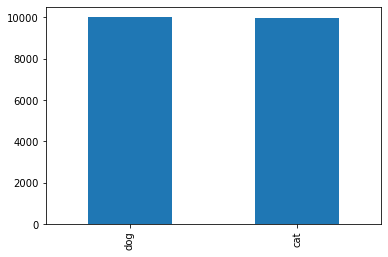

In [34]:
train_df['category'].value_counts().plot.bar()

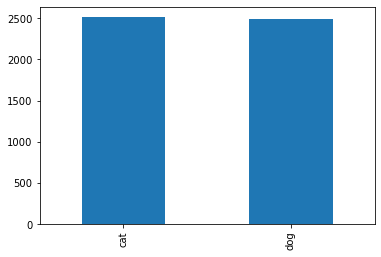

In [35]:
validate_df['category'].value_counts().plot.bar()

In [36]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

Traning Generator

In [46]:
train_datagen = ImageDataGenerator(rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


Validation Generator

In [47]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 0 validated image filenames belonging to 0 classes.


See how our generator work

In [48]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "/input/train/", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 0 validated image filenames belonging to 0 classes.


IndexError: index 0 is out of bounds for axis 0 with size 0

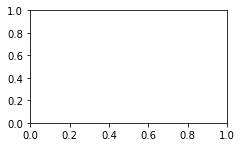

In [49]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

Fit Model

In [25]:
epochs=3 if FAST_RUN else 10
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
1333/1333 [==============================] - 134s 98ms/step - loss: 0.9521 - accuracy: 0.5960 - val_loss: 0.6793 - val_accuracy: 0.6314
Epoch 2/10
1333/1333 [==============================] - 130s 98ms/step - loss: 0.5847 - accuracy: 0.6962 - val_loss: 0.8311 - val_accuracy: 0.6621
Epoch 3/10
1333/1333 [==============================] - 130s 98ms/step - loss: 0.5201 - accuracy: 0.7472 - val_loss: 1.9275 - val_accuracy: 0.5497
Epoch 4/10
1333/1333 [==============================] - 133s 100ms/step - loss: 0.4831 - accuracy: 0.7727 - val_loss: 0.6115 - val_accuracy: 0.7353
Epoch 5/10
1333/1333 [==============================] - 133s 100ms/step - loss: 0.4352 - accuracy: 0.8004 - val_loss: 0.3644 - val_accuracy: 0.8390
Epoch 6/10
1333/1333 [==============================] - 135s 101ms/step - loss: 0.4285 - accuracy: 0.8058 - val_loss: 0.5415 - val_accuracy: 0.7860
Epoch 7/10
1333/1333 [==============================] - 136s 102ms/step - loss: 0.3992 - accuracy: 0.8240 - val_los

Save Model

In [26]:
model.save_weights("model.h5")

Visualize Training

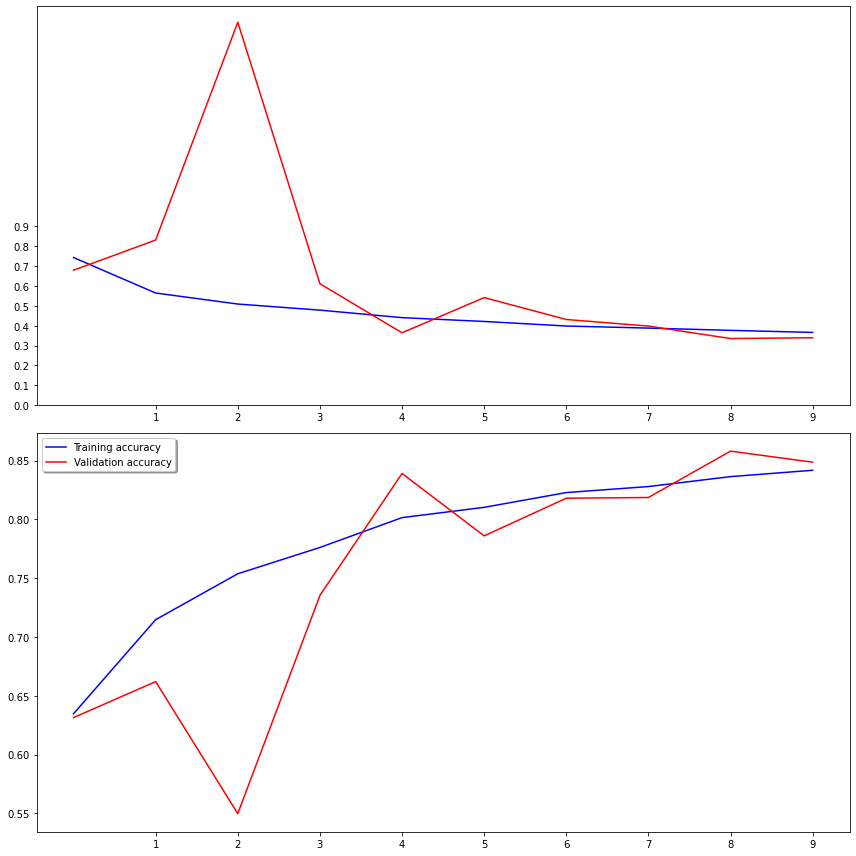

In [27]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['accuracy'], color='b', label="Training accuracy")
ax2.plot(history.history['val_accuracy'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Prepare Testing Data

In [28]:
test_filenames = os.listdir("/kaggle/working/test1")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

Create Testing Generator

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "/kaggle/working/test1/", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 12500 validated image filenames.


Predict

In [30]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))

/opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:1905: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


For categoral classication the prediction will come with probability of each category. So we will pick the category that have the highest probability with numpy average max



In [31]:
test_df['category'] = np.argmax(predict, axis=-1)

We will convert the predict category back into our generator classes by using train_generator.class_indices. It is the classes that image generator map while converting data into computer vision

In [32]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

From our prepare data part. We map data with {1: 'dog', 0: 'cat'}. Now we will map the result back to dog is 1 and cat is 0

In [33]:
test_df['category'] = test_df['category'].replace({ 'dog': 1, 'cat': 0 })

Virtaulize Result

<AxesSubplot:>

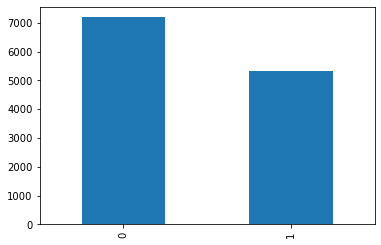

In [34]:
test_df['category'].value_counts().plot.bar()

See predicted result with images

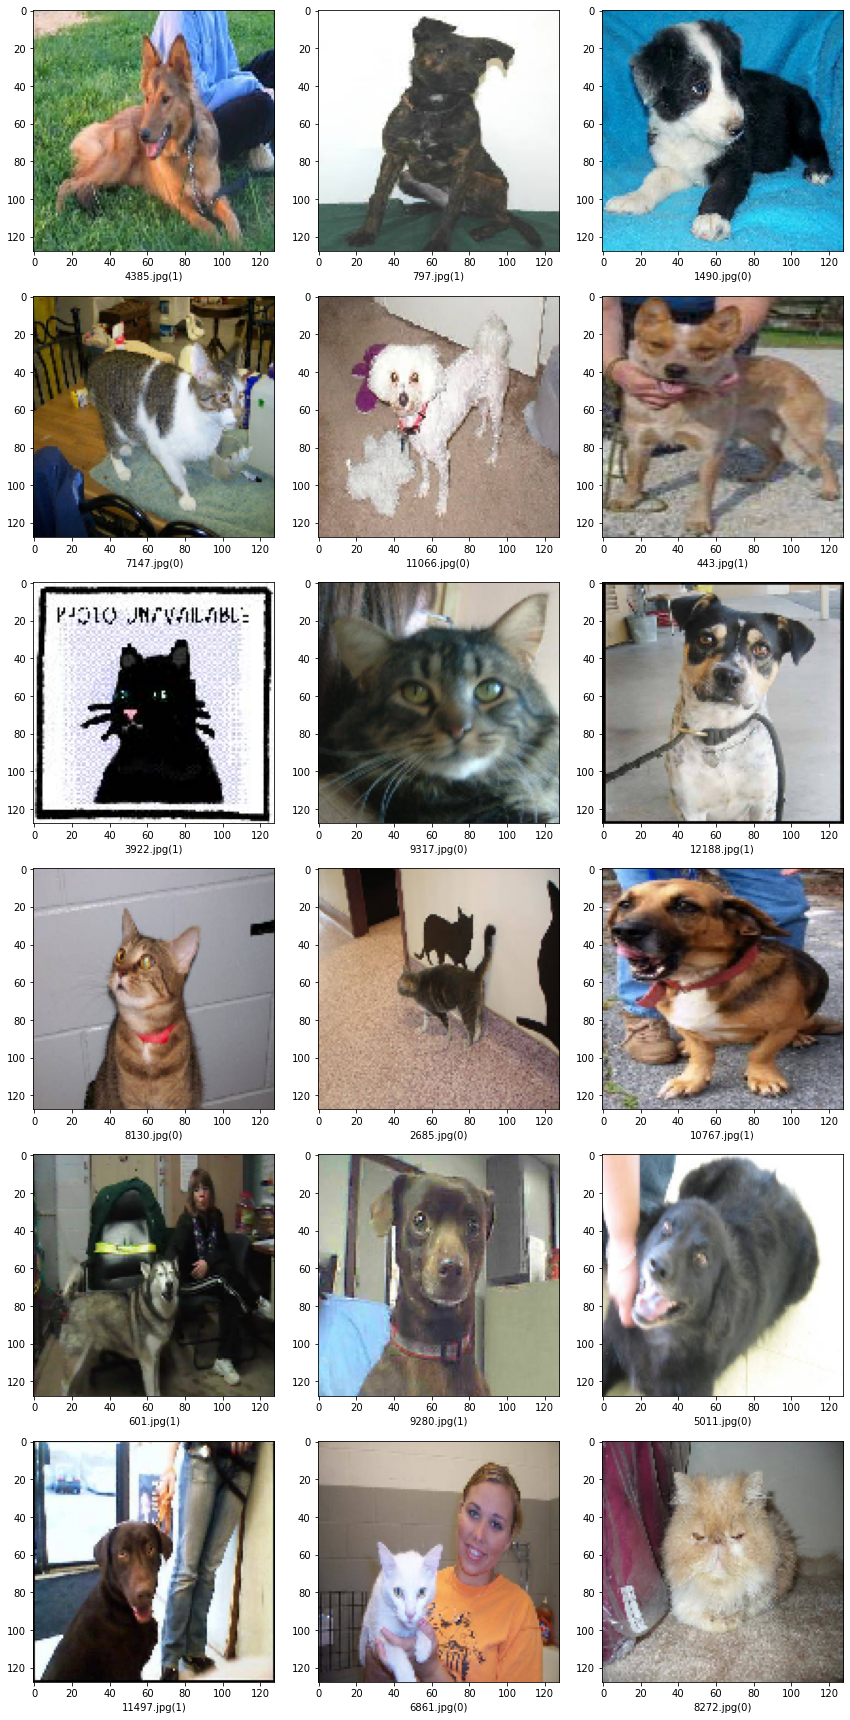

In [35]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("/kaggle/working/test1/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

Submission File Generation

In [36]:
submission_df = test_df.copy()
submission_df['id'] = submission_df['filename'].str.split('.').str[0]
submission_df['label'] = submission_df['category']
submission_df.drop(['filename','category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)

In [37]:
FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Prepare Traning Data

In [38]:
filenames = os.listdir("/kaggle/working/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(1)
    else:
        categories.append(0)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})

See Total In count

'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [39]:
resnet_weights_path = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


In [40]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D

num_classes = 2
resnet_weights_path = 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5'


my_new_model = Sequential()
my_new_model.add(ResNet50(include_top=False, pooling='avg', weights=resnet_weights_path))
my_new_model.add(Dense(num_classes, activation='softmax'))

# Indicate whether the first layer should be trained/changed or not.
my_new_model.layers[0].trainable = False


UnimplementedError: File system scheme 'https' not implemented (file: 'https://github.com/fchollet/deep-learning-models/releases/download/v0.2/resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5')

Compile the Model

In [41]:
my_new_model.compile(optimizer='sgd', 
                     loss='categorical_crossentropy', 
                     metrics=['accuracy'])

Fit Model

In [42]:
!ls images/train/upright

ls: cannot access 'images/train/upright': No such file or directory


In [43]:
from tensorflow.keras.preprocessing.image import load_img
img = load_img('images/kaggle/input/dogs-vs-cats/train.zip')
img

FileNotFoundError: [Errno 2] No such file or directory: 'images/kaggle/input/dogs-vs-cats/train.zip'

In [44]:
from tensorflow.keras.preprocessing.image import load_img
img = load_img('/kaggle/input/dogs-vs-cats/test1.zip')
img

UnidentifiedImageError: cannot identify image file <_io.BytesIO object at 0x7f4eaae467d0>

In [45]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

image_size = 224
data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_directory(
                                        directory='images/train',
                                        target_size=(image_size, image_size),
                                        batch_size=10,
                                        class_mode='categorical')



validation_generator = data_generator.flow_from_directory(
                                        directory='images/val',
                                        target_size=(image_size, image_size),
                                        class_mode='categorical')



# fit_stats below saves some statistics describing how model fitting went
# the key role of the following line is how it changes my_new_model by fitting to data
fit_stats = my_new_model.fit_generator(train_generator,
                                       epochs=2,
                                       steps_per_epoch=22,
                                       validation_data=validation_generator,
                                       validation_steps=1)

#step_4.check()

FileNotFoundError: [Errno 2] No such file or directory: 'images/train'

In [46]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

predict = my_new_model.predict_generator(validation_generator,steps = nb_samples)

In [47]:
import numpy as np
pred = np.argmax(predict, axis=1)

In [48]:
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(pred,test_generator.labels)

AttributeError: 'DataFrameIterator' object has no attribute 'classes'

In [49]:
accuracy_score(pred,test_generator.labels)

AttributeError: 'DataFrameIterator' object has no attribute 'classes'

In [50]:
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img

image_size = 224
data_generator = ImageDataGenerator(preprocess_input)

train_generator = data_generator.flow_from_directory(
                                        directory='images/train',
                                        target_size=(image_size, image_size),
                                        batch_size=10,
                                        class_mode='categorical')



validation_generator = data_generator.flow_from_directory(
                                        directory='images/val',
                                        target_size=(image_size, image_size),
                                        class_mode='categorical')



# fit_stats below saves some statistics describing how model fitting went
# the key role of the following line is how it changes my_new_model by fitting to data
fit_stats = my_new_model.fit_generator(train_generator,
                                       epochs=2,
                                       steps_per_epoch=22,
                                       validation_data=validation_generator,
                                       validation_steps=1)

#step_4.check()

FileNotFoundError: [Errno 2] No such file or directory: 'images/train'

Data Augumentation

In [51]:
from tensorflow.python.keras.preprocessing.image import ImageDataGenerator
data_generator_with_aug = ImageDataGenerator(preprocessing_function=preprocess_input,
                                   horizontal_flip=True,
                                   width_shift_range = 0.2,
                                   height_shift_range = 0.2)

train_generator_aug = data_generator_with_aug.flow_from_directory(
        'images/train',
        target_size=(image_size, image_size),
        batch_size=24,
        class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: 'images/train'

In [52]:
filenames = validation_generator.filenames
nb_samples = len(filenames)

predict = my_new_model.predict_generator(validation_generator,steps = nb_samples)

In [53]:
data_generator_no_aug = ImageDataGenerator(preprocessing_function=preprocess_input)
validation_generator_no_aug = data_generator_no_aug.flow_from_directory(
        'images/val',
        target_size=(image_size, image_size),
        class_mode='categorical')

FileNotFoundError: [Errno 2] No such file or directory: 'images/val'

In [54]:
fit_stats = my_new_model.fit_generator(train_generator_aug,
                                       epochs=2,
                                       steps_per_epoch=22,
                                       validation_data=validation_generator_no_aug,
                                       validation_steps=1)

NameError: name 'train_generator_aug' is not defined

In [55]:
test_datagen = ImageDataGenerator(preprocess_input)

test_generator = test_datagen.flow_from_directory(
        'images/val',
        target_size=(image_size, image_size),
        color_mode="rgb",
        shuffle = False,
        class_mode='categorical',
        batch_size=1)

filenames = test_generator.filenames
nb_samples = len(filenames)

predict = my_new_model.predict_generator(test_generator,steps = nb_samples)

FileNotFoundError: [Errno 2] No such file or directory: 'images/val'

In [56]:
import numpy as np
pred = np.argmax(predict, axis=1)

In [57]:
from sklearn.metrics import confusion_matrix,accuracy_score
confusion_matrix(pred,test_generator.labels)

AttributeError: 'DataFrameIterator' object has no attribute 'classes'

In [58]:
accuracy_score(pred,test_generator.labels)

AttributeError: 'DataFrameIterator' object has no attribute 'classes'